# Lab 7: Introduction to Markov chains and random graphs

In this lab we will be looking at Markov Processes.  Below is the code to import the modules we will be using throughout this lab.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy as sp
import scipy.stats as st
import pickle as pkl
import csv as csv
import networkx as nx
print ("Modules Imported!")

Modules Imported!


## Introduction to Markov Chains:

A Markov chain $(X[t]: t\geq 0)$ is a sequence of random variables such that the distribution of each variable is determined by the random variable before it.  Equivalently, it is a sequence of states visited by a form of finite state machine with random transitions.  To describe how to generate the chain we specify the initial probability distribution $\pi_0$ and a one-step transition probability matrix $P$.   We assume there is a finite state space described by {0,1,, . . . , $n-1$} for some $n$.  The intial distribution, $\pi(0)$, should be a probability vector (nonnegative entries with sum equal to one) of length $n$.   It consists of the probability the process is in a given state at time zero: ${\pi_i(0)} = P\{X[0]=i\}$ for $0\leq i \leq n-1.$    The matrix $P$ is an $n\times n$ matrix such that each row of the matrix is a probability vector.   If the state of the Markov chain at time $t-1$ is $i$ (in other words, if $X[t-1]=i$), then the (conditional) probability distribution of $X[t]$, the state at time $t$, is given by the ith row of $P.$ Additionally, we can look at the individual entries: $p_{ij}=P\left\{X[t]=j \; \big| \; X[t-1]=i\right\}$.  Below is a class that can be used to create a Markov chain.  An object in this class is created with specified values of $\pi_0$ and $P$, and can be used to calculate the state distribution at any time or to generate a sample path (i.e. a variate of the sequence of states) of the Markov chain.  

The state distributions are determined recursively as follows.  If $$\pi_i(t)=P\{X[t]=i\}$$ then by the law of total probability, $$\pi_j(t)= P\{X[t]=j\}=\sum_i P\{X[t-1]=i,X[t]=j\} =\sum_i \pi_i(t-1)p_{i,j}$$  That is, if we view $\pi(t)$ as a row vector for all $t,$ then $\pi(t)=\pi(t-1)P,$  where we have used multiplication of a row vector by a matrix.  (A nice introduction to Markov chains is given on wikipedia.)

In [3]:
# Markov chain object similar to random variable objects in scipy.stats (st)

class Markov_chain:
    def __init__(self, P, pi0):   # The transition probability matrix and initial distribution are passed
        self.P = P 
        self.pi0 = pi0
        self.n=np.size(pi0)
        if np.shape(P) != (self.n,self.n):
            print ("Error: Shape of P doesn't match pi0")
   
    def rvs(self,T):     # produce a length T segment of variates of the random process
        X = [np.random.choice(self.n, p=self.pi0)] 
        for t in range(1,T):
            X.append(np.random.choice(self.n, p=self.P[X[t-1],:]))
        return np.array(X)
    
    def pi(self,t):    # produce probability distribution at time t
        pi_new=self.pi0
        for s in range(t):
            pi_new = np.dot(pi_new, P)    # one step update of probability distribution
        return pi_new

# An example of how you can use the class to create and run through a simple two state chain
P=np.array([[0.9,0.1],[0.1,0.9]])
pi0=np.array([0.1,0.9])
print ('Simulated state sequence')
markov=Markov_chain(P,pi0)  
print (markov.rvs(100))
for t in range(20):
    print ("Distribution at time", t, ":", markov.pi(t))

Simulated state sequence
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1
 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Distribution at time 0 : [0.1 0.9]
Distribution at time 1 : [0.18 0.82]
Distribution at time 2 : [0.244 0.756]
Distribution at time 3 : [0.2952 0.7048]
Distribution at time 4 : [0.33616 0.66384]
Distribution at time 5 : [0.368928 0.631072]
Distribution at time 6 : [0.3951424 0.6048576]
Distribution at time 7 : [0.41611392 0.58388608]
Distribution at time 8 : [0.43289114 0.56710886]
Distribution at time 9 : [0.44631291 0.55368709]
Distribution at time 10 : [0.45705033 0.54294967]
Distribution at time 11 : [0.46564026 0.53435974]
Distribution at time 12 : [0.47251221 0.52748779]
Distribution at time 13 : [0.47800977 0.52199023]
Distribution at time 14 : [0.48240781 0.51759219]
Distribution at time 15 : [0.48592625 0.51407375]
Distribution at time 16 : [0.488741 0

We won't go into this deeply, but notice how as the distributions change in time, they appear to be converging. For some Markov chains, there exists a limit for the distribution. If this occurs then the limit distribution $\pi$ satisfies $\pi = \pi P$ and $\pi$ is called an *equilibrium distribution.*

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 1:</SPAN>** Imagine that the states {0, . . . , n-1} of a particular Markov chain are the nodes of a ring graph, with state 0 following state n-1.   Create a Markov_chain object for n=6 with inital state 0 (so x[0]=0 with probability one) with the following transition probabilities:  given X[t-1]=i, X[t] is equal to i with probability 0.8 and to i+1 (modulo n) with probability 0.2.
<ol>
<li> Print the first 100 states for a simulation of the chain.</li>
<li> Simulate the chain for 10,000 time units, and calculate the number of complete revolutions the chain makes around the ring, divided by 10,000.  This is an estimate of the long term cycle rate for the Markov chain.  Repeat the experiment ten times to get an idea of the variation from one experiment to the next.</li>
<li> Give an analytical argument for what the long term cycle rate for this Markov chain should be.</li>

In [8]:
# Your code here
P=np.array([[0.8,0.2,0,0,0,0],[0,0.8,0.2,0,0,0],[0,0,0.8,0.2,0,0],[0,0,0,0.8,0.2,0],[0,0,0,0,0.8,0.2],[0.2,0,0,0,0,0.8]])
pi0=np.array([1.,0,0,0,0,0])
markov=Markov_chain(P,pi0)  
print ('First 100 states:',markov.rvs(100))

answer = []
for i in range(10):
    count = 0
    sim = markov.rvs(10000)
    for j in range(len(sim)-1):
        if (sim[j]-sim[j+1] == 5):
            count += 1
    answer.append(count/10000)
print()
print('10 long term cycle rate experiments:',answer)

First 100 states: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 4 5 5 5 5 5 5 5 5 5 5 5 0
 1 2 3 3 3 3 3 4 4 4 4 5 0 0 1 1 1 2 3 3 3 4 4 4 4 4 4 5 5 0 0 0 0 0 0 1 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 5 5]

10 long term cycle rate experiments: [0.0322, 0.0333, 0.0331, 0.0328, 0.0338, 0.0324, 0.0336, 0.0331, 0.0327, 0.0337]


__Answer:__ The long term cycle rate for this Markov chain seems to be 1/3 since all of the simulation results hover around that value.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 1</SPAN>**

## Markov Gibberish

Let's look at some applications of a Markov Chain. When I was younger I remember using AIM (instant messenger) to talk to my friends. At some point people started to create bots which could hold conversations with users. Of course we had fun trying to get them to say things that didn't make sense, but the idea that it could generate somewhat relevant conversations was pretty cool. We're going to build a rudimentary version of that here. The code below generates text based on a large sample text, such that each word is generated based on the two words just before it.  The generated sequence of words is given by a 2-Markov chain (here "2" means that the distribution of the value of each word is determined by the two previous words, instead of just the one previous word).  That means that any three consecutive words in the generated text are also consecutive words somewhere in the sample text.   If words w1 w2 were the last two words added to the generated text string, then to generate the next word we look for all occurrences of w1 w2 as consecutive words in the sample text, and see what word was just after them for each occurrence.   The randomly generated text selects the next word to match one of those occurrences, selected at random with equal probability.

In [25]:
# Based on http://agiliq.com/blog/2009/06/generating-pseudo-random-text-with-markov-chains-u/    --BH
# Next word of random string is selected from possible word that follow the last two words.


class Markov_text:
    def __init__(self, open_file):   # The single parameter passed is a file handle
        self.cache = {}  # Will be dictionary mapping a key (two consecutive words) to possible next word
        self.open_file = open_file
        self.words = self.file_to_words()  # Read the words from the file into array self.words
        self.word_size = len(self.words)
        self.database()   # Fill in the dictionary
        self.cache1 = {}
        self.cache3 = {}
        self.database1()
        self.database3()
       
       
    def file_to_words(self):
        self.open_file.seek(0)
        data = self.open_file.read()
        words = data.split()
        return words
           
       
    def triples(self):
    #Generates triples from the given data string. So if our string were
    # "What a lovely day", we'd generate (What, a, lovely) and then (a, lovely, day)."""
           
        if self.word_size < 3:
            return
         
        for i in range(self.word_size - 2):
            yield (self.words[i], self.words[i+1], self.words[i+2])    #Like return but returns a generator to be used once
               
    def database(self):
        for w1, w2, w3 in self.triples():
            key = (w1, w2)
            if key in self.cache:
                self.cache[key].append(w3)
            else:
                self.cache[key] = [w3]
                         
    def generate_markov_text(self, size=100):
        seed = np.random.randint(0, self.word_size-3)
        w1, w2 = self.words[seed], self.words[seed+1]  # Initial key is (w1,w2)
        gen_words = [w1,w2]
        for i in range(size):
            w1, w2 = w2, np.random.choice(self.cache[(w1, w2)])
            gen_words.append(w2)
        return ' '.join(gen_words)
    
    def triples1(self):
    #Generates triples from the given data string. So if our string were
    # "What a lovely day", we'd generate (What, a, lovely) and then (a, lovely, day)."""
           
        if self.word_size < 2:
            return
         
        for i in range(self.word_size - 1):
            yield (self.words[i], self.words[i+1])    #Like return but returns a generator to be used once
               
    def database1(self):
        for w11, w21 in self.triples1():
            key = (w11)
            if key in self.cache1:
                self.cache1[key].append(w21)
            else:
                self.cache1[key] = [w21]
                         
    def generate_markov_text1(self, size=100):
        seed = np.random.randint(0, self.word_size-2)
        w11 = self.words[seed]  # Initial key is (w1,w2)
        gen_words = [w11]
        for i in range(size):
            w11 = np.random.choice(self.cache1[(w11)])
            gen_words.append(w11)
        return ' '.join(gen_words)
                
    def triples3(self):
    #Generates triples from the given data string. So if our string were
    # "What a lovely day", we'd generate (What, a, lovely) and then (a, lovely, day)."""
           
        if self.word_size < 4:
            return
         
        for i in range(self.word_size - 3):
            yield (self.words[i], self.words[i+1], self.words[i+2], self.words[i+3])    #Like return but returns a generator to be used once
               
    def database3(self):
        for w13, w23, w33, w43 in self.triples3():
            key = (w13, w23, w33)
            if key in self.cache3:
                self.cache3[key].append(w43)
            else:
                self.cache3[key] = [w43]
                         
    def generate_markov_text3(self, size=100):
        seed = np.random.randint(0, self.word_size-4)
        w13, w23, w33 = self.words[seed], self.words[seed+1], self.words[seed+2]  # Initial key is (w1,w2)
        gen_words = [w13, w23, w33]
        for i in range(size):
            w13, w23, w33 = w23, w33, np.random.choice(self.cache3[(w13,w23,w33)])
            gen_words.append(w33)
        return ' '.join(gen_words)  
        
file_ = open('Jeeves.txt')
markov = Markov_text(file_)   # Creates the object markov using the file
markov.generate_markov_text()   # Generate random text

# The above has a slight bug.   It is possible for the key to be the
# last two words in the text file and have no entry in the dictionary.
# This won't happen if the last two words in the text file appear
# consecutively somewhere else in the file.   -BH

'format used in the old metrop.! "Pretty soft!" he cried. "To have to take a flutter on the yellow-billed cuckoo without rousing a certain disposition towards chumminess in him. "Voules," I said, "but the fact that it can be so happy that he would call a Theosophist, and he was back in a high wind. "How the deuce of a shock. You remember my friend, Mr. Corcoran?" "Yes, please." "Good afternoon." "Good afternoon." "Good afternoon." "Good afternoon." Corky stood there, looking at me in a small book. As for the time of day. "Well, well, well, what?" I said. "Bucks you up!'

With punctuation and everything, this initially looks like a bit of a mess. However, the sentences themselves are coming together and can make a little bit of sense. It is a very primitive version of those bots on instant messaging.

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 2:</SPAN>** Using the class above, do the following:
<ol><li> Find your own text file or copy and paste from somewhere and use the text to create gibberish from that. To work well, your file really needs to contain a large amount of text. The "Jeeves" file was pulled from a short story. Print out your own 100 word gibberish paragraph based on the text file you used.</li>
<li> Rewrite the code to create a 1-Markov Chain of the words instead of the 2-Markov Chain given above. Print out your own 100 word gibberish paragraph from this.</li>
<li> Rewrite the code to create a 3-Markov Chain of the words instead of the 2-Markov Chain given above. Print out your own 100 word gibberish paragraph from this.</li>
<li> Comment on the qualitative differences of your paragraphs using these methods.</li>

In [28]:
# Your code here (add additional code cells if necessary)
file_2 = open('Barney.txt')
markov = Markov_text(file_2)   # Creates the object markov using the file
markov.generate_markov_text()

'embrace the fat purple dinosaur prance and roll across the nation. "YES!!!" "Well, that\'s wonderful!" reeled Barney. "But do you know it\'s not nice to lie? Shame, shame, shame, naughty Jeremy!" Jeremy reached for his sister. As he did regain his composure, Jeremy blew out the serated hunting knife and slid it firmly under the Loved One\'s path. It halted, then Jeremy flung himself forward, just as special. All I want to go home". Jeremy examined his wounds and looked into the crowd of children, huddled in fear on the cake. Within minutes, they had eaten every last crumb. Children\'s enthusiasm has'

In [29]:
markov.generate_markov_text1()

'loosely, and painted in the lair of Barney\'s influence had already begun teething. Their heads are going to bed, surrounded by Loved Ones, who were killed during the Loved Ones were always dead and Baby Bop, Barney doll lying beside the guns and the creatures, and Baby Bop. "For shame, Jeremy, we\'ll set of his power will never as the closest one, loves you away too. He had tried to keep him feel just as Jeremy leveled it seemed absurd.... But do you better time to do now?" Jeremy often carrying odd way, and its ghastly debris. The room and Baby'

In [30]:
markov.generate_markov_text3()

'talking about. I bet you just had a bad dream is all. Don\'t you know that I miss you? So does Fran! How could you leave your sister behind like that? " Jeremy watched as a Loved One who led Jeremy to the circle lifted the lid to a rotting old trunk and produced a flat, tightly-bound drum. He gave it to the boy and grabbed him by the arm. The boy screamed and struggled. "Not now, you fool!" bellowed the dinosaur. Jeremy shrieked and fought with the Loved One, who had now dropped his torch and Barney doll, and was trying to'

__Answer:__ When there are more words in the Markov chain, the "gibberish" begins to make more sense and result in something much closer to the original text.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 2</SPAN>**

## Random Graphs and Working with Graphs

Markov chains that are time independent and finite can be represented really well by graphs. I'm sure you've used finite state machines to describe processes or sequences in some of your other classes. They can also be useful in analyzing or describing networks. Networkx is an extensive Python package for generating and analyzing graphs (the kind with nodes and edges) and can also plot them.  The following code adapted from the networkx webpage generates a random undirected graph by placing nodes at random locations within the unit square and connecting nodes together if their distance is less than a specified threshold.

('The center node is located at:', 0.5059152475686686, ',', 0.4657010760009531)
The graph is connected


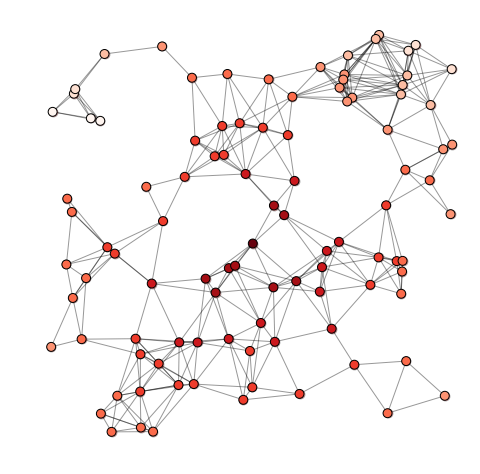

In [3]:
#import networkx as nx

d=0.16 # distance threshold, pairs of nodes within distance d are connected by an edge
G=nx.random_geometric_graph(100,d)  #100 nodes in unit square, distance threshold d
# position is stored as node attribute data for random_geometric_graph
pos=nx.get_node_attributes(G,'pos')  # pos is a dictionary, with the indices as keys, ranging from 0 to 99

# find node nearest to (0.5,0.5), called the center node
dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

print ('The center node is located at:', pos[ncenter][0], ',', pos[ncenter][1])
# color by path length from node near center
p=nx.single_source_shortest_path_length(G,ncenter)  #p is dictionary: keys are nodes, values are distances to center
                                                    #Node not connected to the center node are not listed in p.
                                                    # p include the center node itself.

if nx.is_connected(G):   # The Networkx method is_connected checks for connectness
    print ("The graph is connected")
else: print ("The graph is not connected")

plt.figure(figsize=(8,8))
# nx.draw_networkx_edges(G,pos,nodelist=[ncenter],alpha=0.4)  #All edges are drwn
nx.draw_networkx_edges(G,pos,alpha=0.4)  #All edges are drwn
nx.draw_networkx_nodes(G,pos,alpha=0.3,node_size=80)  #All nodes are drawn but nearly transparent
nx.draw_networkx_nodes(G,pos,nodelist=p.keys(),   # Nodes connected to center node are drawn, closer nodes have darker color
                       node_size=80,
                       node_color=p.values(),
                       cmap=plt.cm.Reds_r)

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axis('off')
plt.savefig('random_geometric_graph.png')
plt.show()

Excellent documentation for NetworkX is available online (search for NetworkX documentation). We find a plethora of classes for generating both undirected graphs (no arrows on the edges) and directed graphs.   Run the code in the above cell a few dozen times, and see how often the graph generated is *connected*, meaning that there is a path through the graph from any node to any other node.   One way a graph could be not connnected is to have an isolated node, which is a node with no neighbors.   Also, try changing the value of the threshold d and seeing the effect on connectivity.

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 3:</SPAN>**   Estimate the probability of connectivity for the above model (100 nodes at random locations in unit square with edges between pairs of nodes at distance d or smaller) for values of d in 0.10, 0.11, . . . , 0.20 by generating 1000 instances for each d and seeing the fraction of them that are connected. Is there a sort of threshold where the odds of a connected graph jumps significantly?

In [5]:
# Your code here
for i in range(10,21):
    d = i/100.
    count = 0
    for j in range(1000):
        graph = nx.random_geometric_graph(100,d)
        if (nx.is_connected(graph)):
            count += 1
    print('Connection probability is:', count/1000., 'for threshold', d)

('Connection probability is:', 0.0, 'for threshold', 0.1)
('Connection probability is:', 0.0, 'for threshold', 0.11)
('Connection probability is:', 0.002, 'for threshold', 0.12)
('Connection probability is:', 0.01, 'for threshold', 0.13)
('Connection probability is:', 0.106, 'for threshold', 0.14)
('Connection probability is:', 0.271, 'for threshold', 0.15)
('Connection probability is:', 0.516, 'for threshold', 0.16)
('Connection probability is:', 0.671, 'for threshold', 0.17)
('Connection probability is:', 0.815, 'for threshold', 0.18)
('Connection probability is:', 0.872, 'for threshold', 0.19)
('Connection probability is:', 0.935, 'for threshold', 0.2)


__Answer:__ The largest jump occurs at a threshold of 0.16, although there are also significant jumps at thresholds 0.15 and 0.17.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 3</SPAN>**

The probability of connectivity can be approximately computed analytically as follows.  You might have noticed in the simulations that the main cause of disconnectivity is having at least one isolated node (no neighbors).

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 4:</SPAN>**   Consider the same model.  Imagine that 100 nodes, numbered from 1 to 100, are independently placed in the unit square with a uniform distribution for each node, and then edges are placed between pairs of nodes at distance d or smaller.  Except for the second half of the fourth part below, your answers should be an expression involving $d.$   No computation is required.
<ol><li> Focus on node 1. Suppose for simplicity it is not near the boundary of the square, so the entire disk of radius $d$ around the node is in the square.   What is the probability that a given other node (say, node 2) is *not* within distance $d$ of node 1?
<li>  What is the probability node 1 is isolated (i.e. *none* of the other nodes is within distance $d$ of node 1)?
<li>  What is the expected number of isolated nodes?
<li>  Assume (this is a reasonable approximation) the total number of isolated nodes has the Poisson distribution with mean given by the answer to the previous problem part.   What is the probability that there are no isolated nodes?
Compute the numerical values for  d in 0.10, 0.11, . . . , 0.20 and compare to the estimated probability the
graph is connected in Problem 3. </ol>

__Answer:__ 
1. 1 - ($\Pi$*$d^2$)
2. $(1 - (\Pi*d^2))$^99
3. 100 * $(1 - (\Pi*d^2))$^99
4. d(0.10) =  0.014375
   d(0.11) =  0.115735
   d(0.12) =  0.359769
   d(0.13) =  0.636824
   d(0.14) =  0.830971
   d(0.15) =  0.931942
   d(0.16) =  0.975467
   d(0.17) =  0.991915
   d(0.18) =  0.997579
   d(0.19) =  0.999333
   d(0.20) =  0.999832
   These probabilities look very similar once they start to grow.  The isolated node probability is non-zero immediately, but the connected graph probability can only begin to grow at a later threshold.  The probabilities are different because you can have a disconnected graph with zero isolated nodes, but cannot have a connected graph with an isolated node.

In [ ]:
# Your code here (if necessary)


**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 4</SPAN>**

## Lab Questions:

Make sure to complete all lab questions 1-4 for this weeks lab.

<div class="alert alert-block alert-warning"> 
## Academic Integrity Statement ##

By submitting the lab with this statement, you declare you have written up the lab entirely by yourself, including both code and markdown cells. You also agree that you should not share your code with anyone else. Any violation of the academic integrity requirement may cause an academic integrity report to be filed that could go into your student record. See <a href="https://provost.illinois.edu/policies/policies/academic-integrity/students-quick-reference-guide-to-academic-integrity/">Students' Quick Reference Guide to Academic Integrity</a> for more information. 